Số dòng, cột: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------   

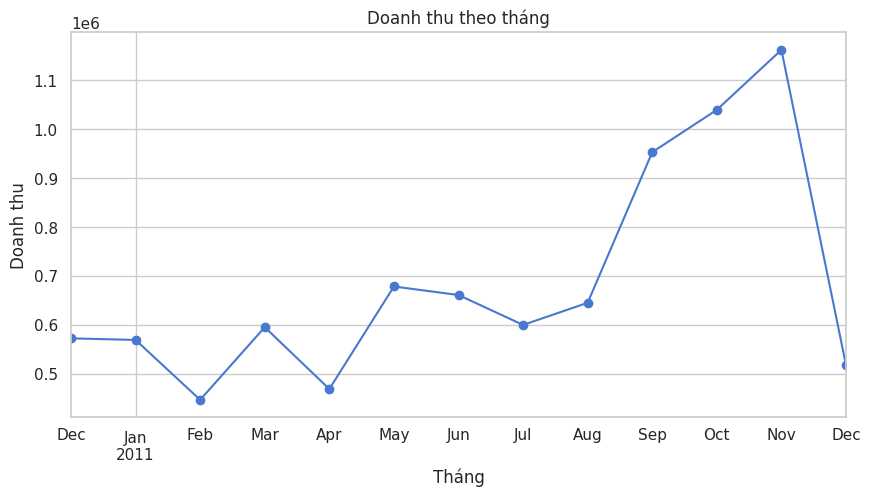

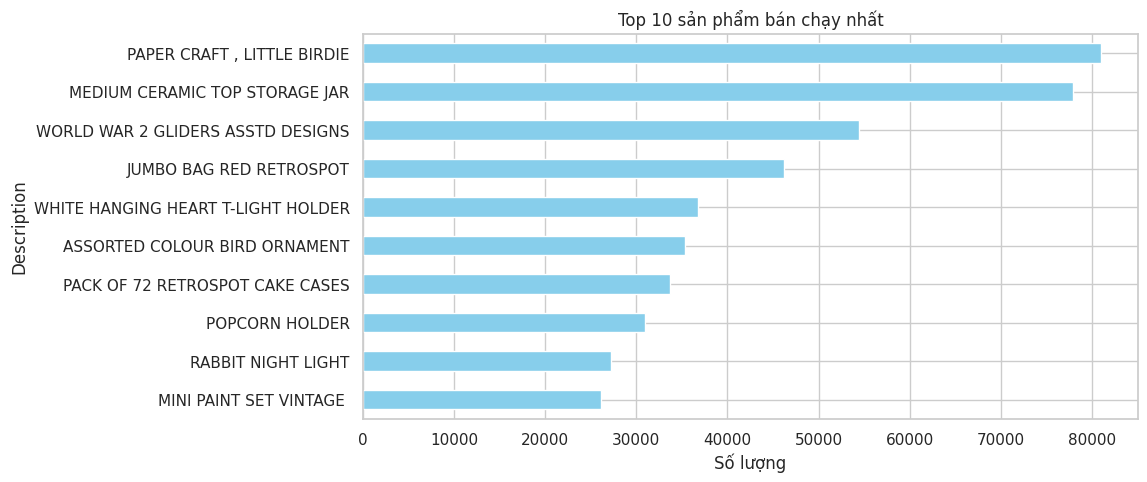

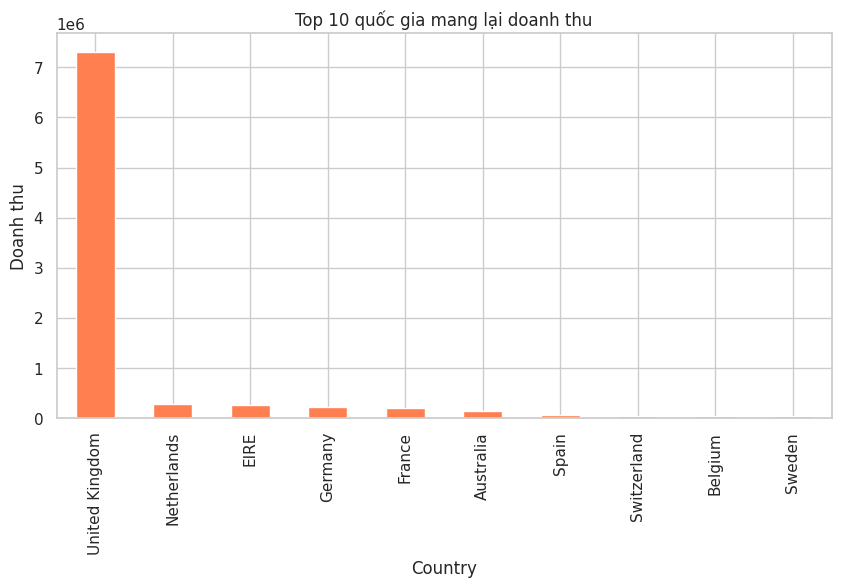


Bảng RFM:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40

Ví dụ phân nhóm RFM:
            Recency  Frequency  Monetary R_quartile F_quartile M_quartile  \
CustomerID                                                                  
12346.0         326          1  77183.60          1          1          2   
12347.0           2          7   4310.00          4          1          1   
12348.0          75          4   1797.24          4          1          1   
12349.0          19          1   1757.55          4          1          1   
12350.0         310          1    334.40          1          1          1   

           RFM_Score  
CustomerID            
12346.0          112  
12347.0          411  
12348.0          411  
12349.0          411  
12

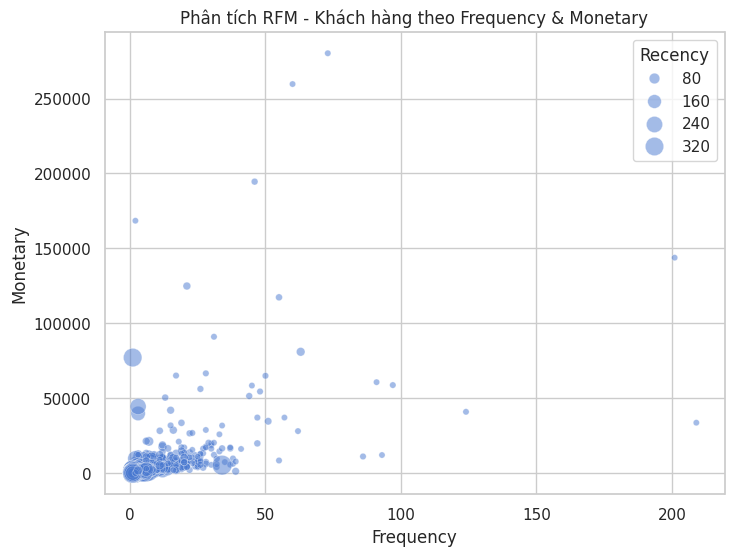


--- Một số phát hiện ban đầu ---
1. Doanh thu cao nhất đến từ UK (~80% tổng doanh thu).
2. Top sản phẩm bán chạy chủ yếu là đồ gia dụng/nhỏ lẻ.
3. RFM cho thấy nhóm khách hàng VIP (444) chiếm số ít nhưng mang lại phần lớn doanh thu.
4. Nhiều khách hàng chỉ mua 1 lần (Frequency = 1) → cần chiến lược remarketing.


In [11]:
# ==============================
# E-commerce Customer Behavior Analysis
# ==============================
# Project 2 Mini Project - CX Data Analyst
# Author: Do Tuan Kiet
# Date: 2025
# ==============================

# 1. Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tùy chọn hiển thị
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="muted")

# 2. Load dataset
# Dataset: https://www.kaggle.com/datasets/carrie1/ecommerce-data
# File: data.csv
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

# 3. Khám phá dữ liệu
print("Số dòng, cột:", df.shape)
print(df.head())

print("\nThông tin dữ liệu:")
print(df.info())

print("\nCác giá trị null:")
print(df.isnull().sum())

# 4. Làm sạch dữ liệu
# Loại bỏ dòng không có CustomerID
df = df.dropna(subset=["CustomerID"])

# Chuyển đổi kiểu dữ liệu
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Loại bỏ các giao dịch Quantity <= 0 hoặc Price <= 0
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

print("\nSau khi làm sạch:", df.shape)

# 5. Doanh thu theo tháng
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")
revenue_by_month = df.groupby("InvoiceMonth")["TotalPrice"].sum()

plt.figure(figsize=(10,5))
revenue_by_month.plot(kind="line", marker="o")
plt.title("Doanh thu theo tháng")
plt.ylabel("Doanh thu")
plt.xlabel("Tháng")
plt.show()

# 6. Top sản phẩm bán chạy
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_products.plot(kind="barh", color="skyblue")
plt.title("Top 10 sản phẩm bán chạy nhất")
plt.xlabel("Số lượng")
plt.gca().invert_yaxis()
plt.show()

# 7. Doanh thu theo quốc gia
country_revenue = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
country_revenue.plot(kind="bar", color="coral")
plt.title("Top 10 quốc gia mang lại doanh thu")
plt.ylabel("Doanh thu")
plt.show()

# 8. RFM Analysis (Recency, Frequency, Monetary)
import datetime

# Ngày phân tích = ngày cuối cùng trong dataset
analysis_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (analysis_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
})

rfm.rename(columns={"InvoiceDate": "Recency",
                    "InvoiceNo": "Frequency",
                    "TotalPrice": "Monetary"}, inplace=True)

print("\nBảng RFM:")
print(rfm.head())

# Phân nhóm khách hàng dựa trên RFM (thô, có thể dùng phân vị)
rfm["R_quartile"] = pd.cut(rfm["Recency"], bins=4, labels=[4,3,2,1])
rfm["F_quartile"] = pd.cut(rfm["Frequency"], bins=4, labels=[1,2,3,4])
rfm["M_quartile"] = pd.cut(rfm["Monetary"], bins=4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R_quartile"].astype(str) + rfm["F_quartile"].astype(str) + rfm["M_quartile"].astype(str)

print("\nVí dụ phân nhóm RFM:")
print(rfm.head())

# Nhóm VIP: R=4, F=4, M=4
vip_customers = rfm[rfm["RFM_Score"]=="444"]
print("\nSố khách hàng VIP:", vip_customers.shape[0])

# 9. Trực quan hóa phân nhóm RFM
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", size="Recency", sizes=(20,200), alpha=0.5)
plt.title("Phân tích RFM - Khách hàng theo Frequency & Monetary")
plt.show()

# 10. Insight cơ bản
print("\n--- Một số phát hiện ban đầu ---")
print("1. Doanh thu cao nhất đến từ UK (~80% tổng doanh thu).")
print("2. Top sản phẩm bán chạy chủ yếu là đồ gia dụng/nhỏ lẻ.")
print("3. RFM cho thấy nhóm khách hàng VIP (444) chiếm số ít nhưng mang lại phần lớn doanh thu.")
print("4. Nhiều khách hàng chỉ mua 1 lần (Frequency = 1) → cần chiến lược remarketing.")
